<a href="https://colab.research.google.com/github/xarvel/DataScience/blob/master/DCGAN_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [231]:
!pip install imageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [232]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LeakyReLU, Flatten, Reshape, BatchNormalization, Input, Conv2D, Dropout, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import BinaryCrossentropy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import time
import os
import tensorflow_datasets as tfds
import imageio
import glob
import IPython

In [233]:
#@title TPU CONFIG

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [234]:
#@title CONFIG

IMAGE_SIZE = 28
IMAGE_CHANNELS = 1
LATENT_DIM = 100
EPOCHS = 20
SAMPLE_INTERVAL = 1
DATASET_SIZE = 60000
SAMPLES_DIR = 'images'
PER_REPILICA_BATCH_SIZE = 16
GLOBAL_BATCH_SIZE = PER_REPILICA_BATCH_SIZE * strategy.num_replicas_in_sync

In [235]:
def preprocess_image(img):
  img = tf.cast(img['image'], tf.float32) / 127.5 - 1.
  # img = tf.expand_dims(img, axis=3)
  return img

ds = tfds.load('mnist', split='train', shuffle_files=True, try_gcs=True)
dataset = ds.map(preprocess_image)
dataset = dataset.shuffle(DATASET_SIZE)
dataset = dataset.repeat()
dataset = dataset.batch(GLOBAL_BATCH_SIZE, drop_remainder=True)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

dataset = strategy.experimental_distribute_dataset(dataset)

In [236]:
class Generator(Model):
  def __init__(self):
    super(Generator, self).__init__()
   
    self.dense_1 = Dense(7 * 7 * 256, use_bias=False, input_shape=(LATENT_DIM,))
    self.bn_1 = BatchNormalization()
    self.lrelu_1 = LeakyReLU()
    self.reshape_1 = Reshape((7, 7, 256));

    self.conv2d_transpose_1 = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)
    self.bn_2 = BatchNormalization()
    self.lrelu_2 = LeakyReLU()

    self.conv2d_transpose_2 = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)

    self.bn_3 = BatchNormalization()
    self.lrelu_3 = LeakyReLU()

    self.conv2d_transpose_3 = Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')

  @tf.function
  def call(self, z, training=False):    
    x = self.dense_1(z)
    x = self.bn_1(x)
    x = self.lrelu_1(x)
    x = self.reshape_1(x)
    x = self.conv2d_transpose_1(x)
    x = self.bn_2(x)
    x = self.lrelu_2(x)
    x = self.conv2d_transpose_2(x)
    x = self.bn_3(x)
    x = self.lrelu_3(x)
    x = self.conv2d_transpose_3(x)

    return x

In [237]:
class Discriminator(Model):
  def __init__(self):
    super(Discriminator, self).__init__()
        
    self.conv2d_1 = Conv2D(64, (5, 5), 
                        strides=(2, 2), 
                        padding='same', 
                        input_shape=[IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS]
                    )

    self.lrelu_1 = LeakyReLU()
    self.dropout_1 = Dropout(0.3)

    self.conv2d_2 = Conv2D(128, (5, 5), strides=(2, 2), padding='same')
    self.lrelu_2 = LeakyReLU()
    self.dropout_2 = Dropout(0.3)
    self.flatten = Flatten()
    self.dense = Dense(1)
  
  @tf.function
  def call(self, image, training=False):    
    x = self.conv2d_1(image)
    x = self.lrelu_1(x)
    x = self.dropout_1(x)
    x = self.conv2d_2(x)
    x = self.lrelu_2(x)
    x = self.dropout_2(x)
    x = self.flatten(x)
    x = self.dense(x)

    return x

In [238]:
with strategy.scope():
  generator = Generator()
  discriminator = Discriminator()

In [239]:
with strategy.scope():
  generator_optimizer = Adam(1e-4)
  discriminator_optimizer = Adam(1e-4)

In [240]:
with strategy.scope():
  cross_entropy = BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)

def discriminator_loss(logits_real: tf.Tensor, logits_fake: tf.Tensor) -> tf.Tensor :
  real_loss = cross_entropy(tf.ones_like(logits_real), logits_real)
  fake_loss = cross_entropy(tf.zeros_like(logits_fake), logits_fake)
  total_loss = real_loss + fake_loss

  return tf.nn.compute_average_loss(total_loss, global_batch_size=GLOBAL_BATCH_SIZE)

def generator_loss(logits_fake: tf.Tensor) -> tf.Tensor:
  loss = cross_entropy(tf.ones_like(logits_fake), logits_fake)
  return tf.nn.compute_average_loss(loss, global_batch_size=GLOBAL_BATCH_SIZE)

In [241]:
rows = 5
cols = 5

noise = np.random.normal(0, 1, (rows * cols, LATENT_DIM))

def sample_images(epoch=0, save=False, show=True):
  gen_imgs = generator(noise)
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  fig.subplots_adjust(
      wspace = 0.0,
      hspace = 0.0
  )
  px = 1/plt.rcParams['figure.dpi']

  fig.set_figheight(IMAGE_SIZE * rows * px)
  fig.set_figwidth(IMAGE_SIZE * cols * px)

  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(gen_imgs[j * cols + i, :,:,0], cmap='gray')
  
      axs[i,j].axis('off')

  # Create folder if not exits
  if not os.path.isdir(SAMPLES_DIR):
    os.makedirs(SAMPLES_DIR, exist_ok=True)

  if save:
    plt.savefig(SAMPLES_DIR + '/image_at_epoch_{:04d}.png'.format(epoch))
    
  if show:
    plt.show()
  else:
    plt.close(fig)

In [242]:
steps_per_epoch = DATASET_SIZE // GLOBAL_BATCH_SIZE

@tf.function
def train_step(iterator):

  def step_fn(images):
    noise = tf.random.normal([PER_REPILICA_BATCH_SIZE, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      gen_predictions = discriminator(generated_images, training=True)
      real_predictions = discriminator(images, training=True)
      
      disc_loss = discriminator_loss(real_predictions, gen_predictions)
      gen_loss = generator_loss(gen_predictions)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_weights)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_weights))
    
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_weights)
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_weights)
    )

    return disc_loss, gen_loss


  disc_loss, gen_loss = strategy.run(step_fn, args=(next(iterator),))

  disc_loss = strategy.reduce(tf.distribute.ReduceOp.SUM, disc_loss, axis=None)
  gen_loss = strategy.reduce(tf.distribute.ReduceOp.SUM, gen_loss, axis=None) 

  return disc_loss, gen_loss

Number of devices: 8
Epoch: 1/20


Current step 468: 100%|██████████| 468/468 [00:28<00:00, 16.32it/s, disc_loss=0.877, gen_loss=1.21]


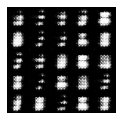

Time for epoch 1 is 30.06968331336975 sec
Epoch: 2/20


Current step 936: 100%|██████████| 468/468 [00:11<00:00, 40.93it/s, disc_loss=0.99, gen_loss=1.03]


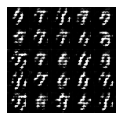

Time for epoch 2 is 12.312253952026367 sec
Epoch: 3/20


Current step 1404: 100%|██████████| 468/468 [00:11<00:00, 40.91it/s, disc_loss=2.01, gen_loss=0.544]


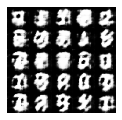

Time for epoch 3 is 12.333735942840576 sec
Epoch: 4/20


Current step 1872: 100%|██████████| 468/468 [00:11<00:00, 40.55it/s, disc_loss=1.22, gen_loss=0.939]


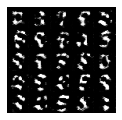

Time for epoch 4 is 12.432055711746216 sec
Epoch: 5/20


Current step 2340: 100%|██████████| 468/468 [00:12<00:00, 38.33it/s, disc_loss=1.23, gen_loss=0.937]


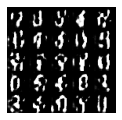

Time for epoch 5 is 13.123612642288208 sec
Epoch: 6/20


Current step 2808: 100%|██████████| 468/468 [00:12<00:00, 37.38it/s, disc_loss=1.34, gen_loss=0.826]


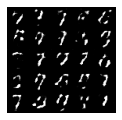

Time for epoch 6 is 14.524256706237793 sec
Epoch: 7/20


Current step 3276: 100%|██████████| 468/468 [00:15<00:00, 30.06it/s, disc_loss=1.47, gen_loss=0.82]


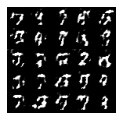

Time for epoch 7 is 16.802445650100708 sec
Epoch: 8/20


Current step 3744: 100%|██████████| 468/468 [00:11<00:00, 39.68it/s, disc_loss=0.939, gen_loss=1.2]


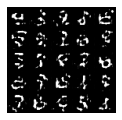

Time for epoch 8 is 12.713187217712402 sec
Epoch: 9/20


Current step 4212: 100%|██████████| 468/468 [00:13<00:00, 35.14it/s, disc_loss=1.21, gen_loss=0.944]


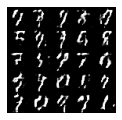

Time for epoch 9 is 14.213536977767944 sec
Epoch: 10/20


Current step 4680: 100%|██████████| 468/468 [00:11<00:00, 40.03it/s, disc_loss=1.18, gen_loss=0.93]


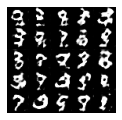

Time for epoch 10 is 12.970298767089844 sec
Epoch: 11/20


Current step 5148: 100%|██████████| 468/468 [00:11<00:00, 39.82it/s, disc_loss=0.674, gen_loss=1.47]


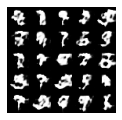

Time for epoch 11 is 12.66148066520691 sec
Epoch: 12/20


Current step 5616: 100%|██████████| 468/468 [00:11<00:00, 40.05it/s, disc_loss=0.88, gen_loss=1.23]


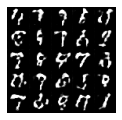

Time for epoch 12 is 12.577340126037598 sec
Epoch: 13/20


Current step 6084: 100%|██████████| 468/468 [00:12<00:00, 38.12it/s, disc_loss=1.13, gen_loss=1.06]


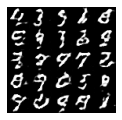

Time for epoch 13 is 13.575772285461426 sec
Epoch: 14/20


Current step 6552: 100%|██████████| 468/468 [00:11<00:00, 39.52it/s, disc_loss=0.986, gen_loss=1.25]


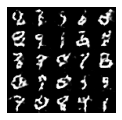

Time for epoch 14 is 13.173785924911499 sec
Epoch: 15/20


Current step 7020: 100%|██████████| 468/468 [00:11<00:00, 40.35it/s, disc_loss=1.1, gen_loss=1.1]


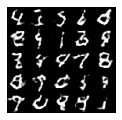

Time for epoch 15 is 12.484273195266724 sec
Epoch: 16/20


Current step 7488: 100%|██████████| 468/468 [00:11<00:00, 39.85it/s, disc_loss=1.16, gen_loss=1.12]


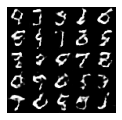

Time for epoch 16 is 12.63243842124939 sec
Epoch: 17/20


Current step 7956: 100%|██████████| 468/468 [00:11<00:00, 40.29it/s, disc_loss=1.24, gen_loss=0.892]


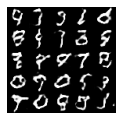

Time for epoch 17 is 12.899895668029785 sec
Epoch: 18/20


Current step 8424: 100%|██████████| 468/468 [00:11<00:00, 40.12it/s, disc_loss=1.28, gen_loss=0.839]


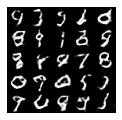

Time for epoch 18 is 12.55369257926941 sec
Epoch: 19/20


Current step 8892: 100%|██████████| 468/468 [00:11<00:00, 40.97it/s, disc_loss=1.2, gen_loss=1.03]


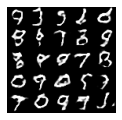

Time for epoch 19 is 12.310163974761963 sec
Epoch: 20/20


Current step 9360: 100%|██████████| 468/468 [00:11<00:00, 40.10it/s, disc_loss=1.22, gen_loss=1.17]


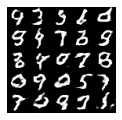

Time for epoch 20 is 12.951085805892944 sec


In [243]:
print ('Number of devices: {}'.format(strategy.num_replicas_in_sync))

train_iterator = iter(dataset)

for epoch in range(1, EPOCHS + 1):
  start = time.time()
  print('Epoch: {}/{}'.format(epoch, EPOCHS))

  pbar = tqdm(range(steps_per_epoch))
  for step in pbar:
    disc_loss, gen_loss = train_step(train_iterator)
 
    pbar.set_postfix({'disc_loss': round(float(disc_loss), 4), 'gen_loss': round(float(gen_loss), 4)})
    pbar.set_description("Current step %s" % generator_optimizer.iterations.numpy())
    
  if epoch % SAMPLE_INTERVAL == 0:
    sample_images(epoch, save=True, show=True);
  
  print('Time for epoch {} is {} sec'.format(epoch, time.time()-start))

In [244]:
anim_file = SAMPLES_DIR + '/all_images.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob(SAMPLES_DIR + '/image_at_epoch_*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)

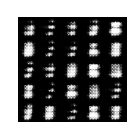

In [245]:
IPython.display.Image(filename=anim_file, embed=True)